# Prévision des données IRIS

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns

# librairie pour le preprocessing
from sklearn.preprocessing import StandardScaler

# librairie pour la modélisation
from sklearn.datasets import load_iris # Iris data
from sklearn.model_selection import train_test_split # split into two sample : training and test
from sklearn.model_selection import cross_val_score # split into two sample : validation and training
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.ensemble import RandomForestClassifier # RandomForest Classifier
from sklearn.svm import SVC, LinearSVC # SVC
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.naive_bayes import GaussianNB # GaussianNB
from sklearn.linear_model import Perceptron # Perceptron
from sklearn.linear_model import SGDClassifier # SGD
from sklearn.tree import DecisionTreeClassifier # Tree Decision

# librairie pour évaluer
from sklearn.metrics import accuracy_score
import optuna

# librairie pour les visualisations
import matplotlib.pyplot as plt  

# librairie pour faire de l'industrialisation
import joblib

In [126]:
# Charger les données iris 
iris = load_iris()
# Créer un DataFrame pandas à partir des données et des noms des colonnes
data_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names) # features
data_iris["target"] = iris.target
# Afficher les 10 premières lignes des données iris
print(data_iris.head(20))

    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                 5.1               3.5                1.4               0.2   
1                 4.9               3.0                1.4               0.2   
2                 4.7               3.2                1.3               0.2   
3                 4.6               3.1                1.5               0.2   
4                 5.0               3.6                1.4               0.2   
5                 5.4               3.9                1.7               0.4   
6                 4.6               3.4                1.4               0.3   
7                 5.0               3.4                1.5               0.2   
8                 4.4               2.9                1.4               0.2   
9                 4.9               3.1                1.5               0.1   
10                5.4               3.7                1.5               0.2   
11                4.8               3.4 

In [127]:
# Voir les valeurs possible de target 
print(data_iris['target'].unique())
# Ajouter le nom des fleurs à partir de la colonne target
data_iris['flower_name'] = data_iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

[0 1 2]


## Nettoyage des données

Vérifions la présence des doublons, des valeurs manquantes et des valeurs aberrantes. 

In [128]:
# Duplicated 

## Recherche des éventuelles duplicated
duplicates = data_iris[data_iris.duplicated()]
print("Doublons :")
print(duplicates)

## Suppression des duplicated
data_iris = data_iris.drop_duplicates(keep='first')


Doublons :
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
142                5.8               2.7                5.1               1.9   

     target flower_name  
142       2   virginica  


In [129]:
# Recherche d'éventuel valeurs manquantes selon les colonnes
missing_values = data_iris.isnull().sum()
print("Valeurs manquantes :")
print(missing_values)

Valeurs manquantes :
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
flower_name          0
dtype: int64


In [130]:
# Recherche des valeurs aberrantes
Q1 = data_iris.drop(['target', 'flower_name'], axis=1).quantile(0.25)
Q3 = data_iris.drop(['target', 'flower_name'], axis=1).quantile(0.75)
IQR = Q3 - Q1
outliers = ((data_iris.drop(['target', 'flower_name'], axis=1) < (Q1 - 1.5 * IQR)) | (data_iris.drop(['target', 'flower_name'], axis=1) > (Q3 + 1.5 * IQR))).any(axis=1)
print("Valeurs aberrantes :")
data_iris.drop(['target', 'flower_name'], axis=1)[outliers]

Valeurs aberrantes :


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
15,5.7,4.4,1.5,0.4
32,5.2,4.1,1.5,0.1
33,5.5,4.2,1.4,0.2
60,5.0,2.0,3.5,1.0


In [131]:
print(f"la borne inférieure est \n {Q1 - 1.5 * IQR} et la borne supérieure est \n {Q3 + 1.5 * IQR}")

la borne inférieure est 
 sepal length (cm)    3.15
sepal width (cm)     2.05
petal length (cm)   -3.65
petal width (cm)    -1.95
dtype: float64 et la borne supérieure est 
 sepal length (cm)     8.35
sepal width (cm)      4.05
petal length (cm)    10.35
petal width (cm)      4.05
dtype: float64


- Lorsqu'on observe les bornes inférieurs pour les variables associés au pétale, on constate qu'il n'y a pas besoin de supprimer les valeurs aberrantes si ils sont très faibles. 

- Il faut donc davantage se concentrer sur la variable "sepal width" car c'est elle qui renvoie des valeurs aberrantes précédemment. En effet, aucune valeur présente dans la sortie n'entre dans l'intervalle.  

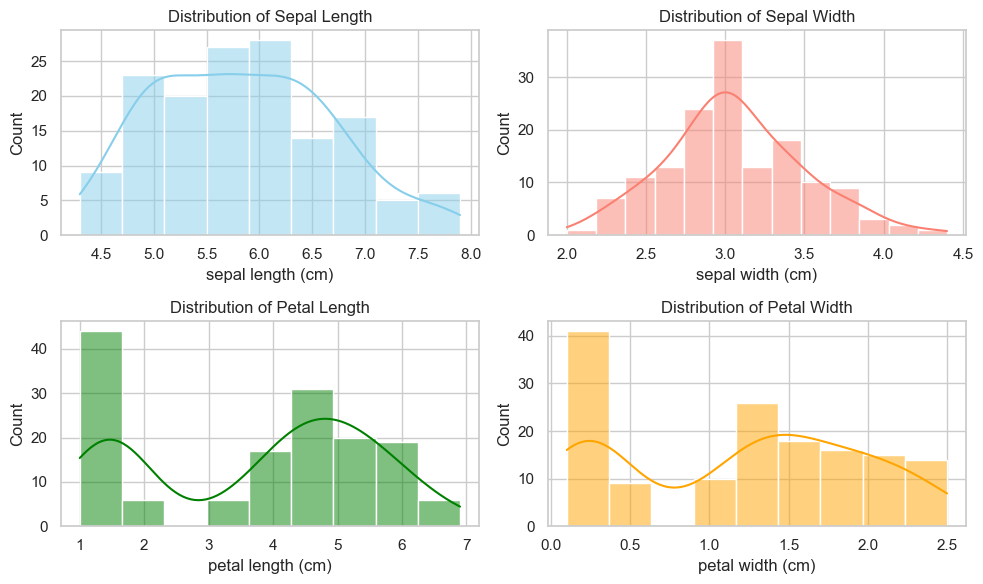

In [132]:
# Vérifier si ces valeurs aberrantes sont intéressantes dans le cadre de notre étude
# Définir le style de seaborn
sns.set(style="whitegrid")

# Tracer les diagrammes de distribution pour chaque variable
plt.figure(figsize=(10, 6))

# Sepal Length
plt.subplot(2, 2, 1)
sns.histplot(data=data_iris, x='sepal length (cm)', kde=True, color='skyblue')
plt.title('Distribution of Sepal Length')

# Sepal Width
plt.subplot(2, 2, 2)
sns.histplot(data=data_iris, x='sepal width (cm)', kde=True, color='salmon')
plt.title('Distribution of Sepal Width')

# Petal Length
plt.subplot(2, 2, 3)
sns.histplot(data=data_iris, x='petal length (cm)', kde=True, color='green')
plt.title('Distribution of Petal Length')

# Petal Width
plt.subplot(2, 2, 4)
sns.histplot(data=data_iris, x='petal width (cm)', kde=True, color='orange')
plt.title('Distribution of Petal Width')

plt.tight_layout()
plt.show()

Ces données aberrantes semblent tout de même cohérent lorsqu'on visualise les deux premières graphiques. En revanche, dans les deux derniers graphiques, on constate une distribution non familière avec une forte présence de faible valeur pour la longueur et la largeur des pétales. Ces valeurs semblent être mis complétement à l'écart des autres valeurs. 

Toutefois, comme elles sont dans l'intervalle, il n'est pas nécessaire de les éliminer. De même, on peut conserver les valeurs aberrantes pour le sepal width.

In [133]:
# Mettre la variable "target" en catégorielle
data_iris['target'] = data_iris['target'].astype('category')

## Description des données 
- étude des corrélations entre les différentes variables quantitatives (nuage de points)

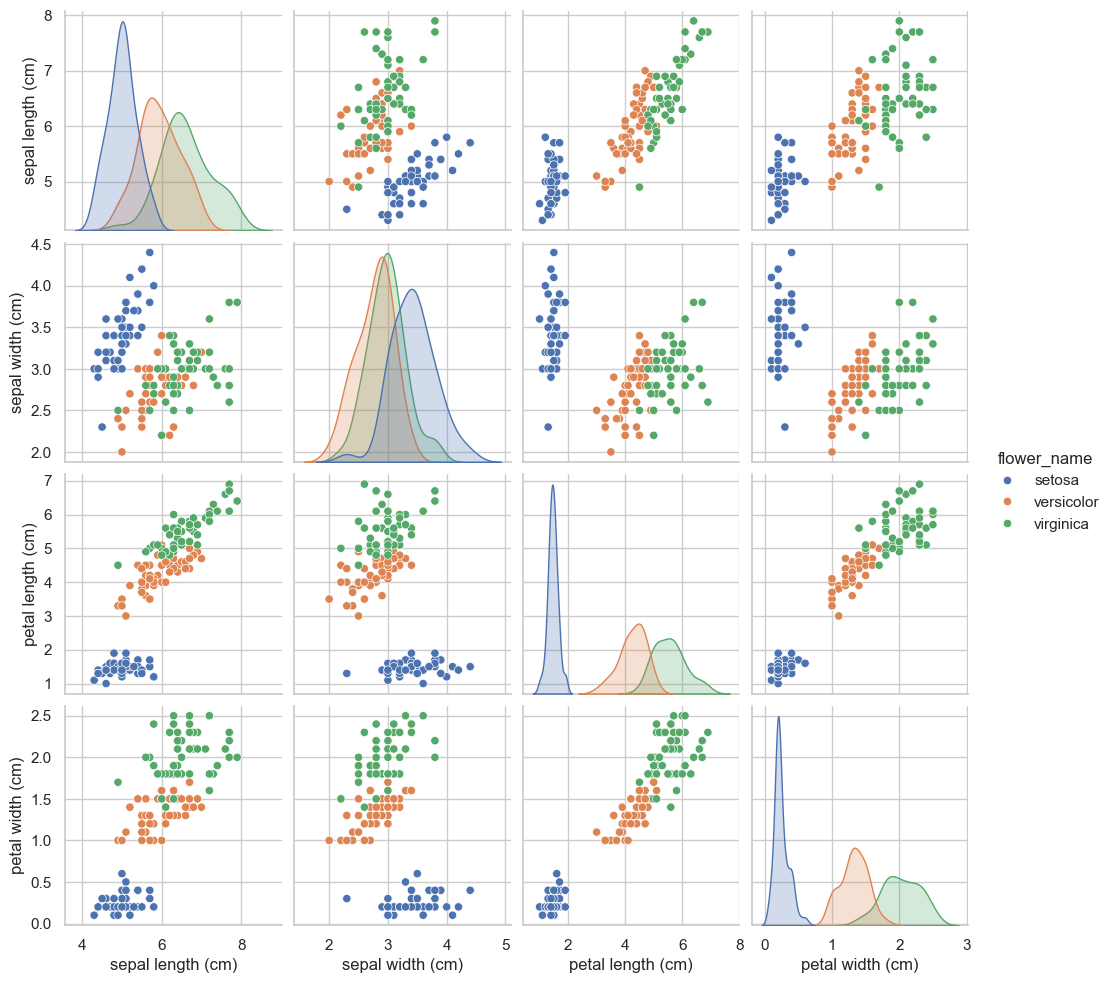

In [134]:
sns.pairplot(data_iris, hue='flower_name')

- Au niveau de la répartition des fleurs, on constate que le "setosa" est à part des autres fleurs. 
- À l'oeil, on observe une corrélation existe entre les variables "petal width" et "petal length". Une légère corrélation peut être remarquer entre "petal length" et "sepal length". 

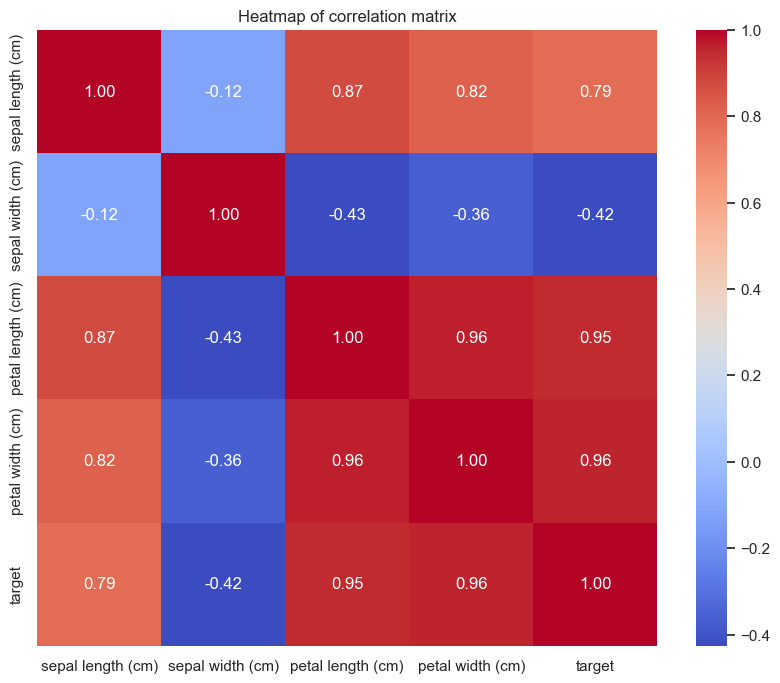

In [135]:
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_iris.drop(["flower_name"], axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of correlation matrix')
plt.show()

- On constate une forte colinéarité entre les variables "petal width" et "target", ainsi que "petal length" et "target".
- On retrouve une forte corrélation entre les différentes variables. 

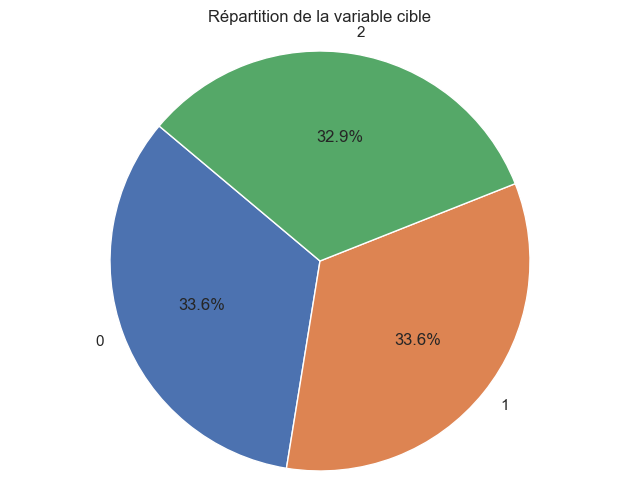

In [136]:
# Compter les occurrences de chaque classe dans la variable cible
target_counts = data_iris['target'].value_counts()

# Extraire les étiquettes et les valeurs à partir du comptage
labels = target_counts.index
sizes = target_counts.values

# Créer le diagramme circulaire
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Répartition de la variable cible')
plt.axis('equal')  # Assure que le diagramme est circulaire
plt.show()

Les données sont équilibrées.

## Diviser en deux échantillons

In [137]:
X = data_iris.drop(['target', 'flower_name'], axis=1) # feature
y = data_iris['target'] # target

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [139]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Modélisation

In [140]:
## Logitistic Regression (penalty 'l1')

#### Define model parameter
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear') # Logistic regression with penalty 'l1' 
logreg_elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5) # Logistic regression with penalty 'elacticnet'

#### Fitting
logreg_l1.fit(X_train_scaled, y_train)
logreg_elastic_net.fit(X_train_scaled, y_train)

### Prediction 
y_pred_logreg_l1 = logreg_l1.predict(X_test_scaled)
y_pred_logreg_elastic_net = logreg_elastic_net.predict(X_test_scaled)

In [142]:
## Logitistic Regression (penalty 'elasticnet')

#### Définir la fonction objective
def objective(trial):
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)  # Exploration de l'hyperparamètre l1_ratio entre 0 et 1
    
    # Créer le modèle de régression logistique avec penalty='elasticnet'
    model = LogisticRegression(penalty='elasticnet', l1_ratio=l1_ratio, solver='saga')
    
    # Calculer le score de validation croisée (utilisation de la précision pour l'exemple)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

#### Créer un objet Optuna pour l'optimisation
study = optuna.create_study(direction='maximize')  # On cherche à maximiser la précision

#### Exécuter l'optimisation
study.optimize(objective, n_trials=100)

#### Afficher les meilleurs hyperparamètres et le score associé
print("Meilleurs hyperparamètres:", study.best_params)
print("Meilleur score de précision:", study.best_value)

#### Define model parameter
logreg_elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=study.best_params['l1_ratio']) # Logistic regression with penalty 'elacticnet'

#### Fitting
logreg_elastic_net.fit(X_train_scaled, y_train)

### Prediction 
y_pred_logreg_elastic_net = logreg_elastic_net.predict(X_test_scaled)

[I 2024-03-26 23:29:08,501] A new study created in memory with name: no-name-6548d4e8-da97-45e7-b015-3ff428c50b07
/var/folders/xx/01dz8x2j0c58d1hmyyx2c3b80000gn/T/ipykernel_15149/788678732.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)  # Exploration de l'hyperparamètre l1_ratio entre 0 et 1
/Users/ranu/Documents/Programming-training/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ranu/Documents/Programming-training/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ranu/Documents/Programming-training/venv/lib/python3.12/site-packages/sklearn

Meilleurs hyperparamètres: {'l1_ratio': 0.1778390587212274}
Meilleur score de précision: 0.9579710144927537


In [143]:
## Support vector machine 

#### Define model parameter
svc = SVC()

#### Fitting
svc.fit(X_train_scaled, y_train)

### Prediction 
y_pred_svc = svc.predict(X_test_scaled)

In [145]:
## Gaussian Naive Bayesian

#### Define model parameter
gaussian = GaussianNB()

#### Fitting
gaussian.fit(X_train_scaled, y_train)

### Prediction 
y_pred_gaussian = gaussian.predict(X_test_scaled)

In [146]:
## Perceptron 

#### Define model parameter
perceptron = Perceptron()

#### Fitting
perceptron.fit(X_train_scaled, y_train)

### Prediction 
y_pred_perceptron = perceptron.predict(X_test_scaled)

In [147]:
## Random Forest Model

#### Define model parameter
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

#### Fitting 
rf.fit(X_train_scaled, y_train)

#### Prediction 
y_pred_rf = rf.predict(X_test_scaled)

## Évaluation de la performance des modèles de machine learning

Évaluer la performance de chaque classifier. 

In [148]:
# Assess the accuracy of each classifier
acc_logreg_l1 = accuracy_score(y_test, y_pred_logreg_l1)
acc_logreg_elastic_net = accuracy_score(y_test, y_pred_logreg_elastic_net)
acc_svc = accuracy_score(y_test, y_pred_svc)
acc_gaussian = accuracy_score(y_test, y_pred_gaussian)
acc_perceptron = accuracy_score(y_test, y_pred_perceptron)
acc_rf = accuracy_score(y_test, y_pred_rf)

In [149]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression (penalty = l1)', 'Logistic Regression (penalty = elastic-net)',
              'Random Forest', 'Naive Bayes', 'Perceptron' 
              ],
    'Score': [acc_svc, acc_logreg_l1, acc_logreg_elastic_net,
              acc_rf, acc_gaussian, acc_perceptron]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,0.966667
1,Logistic Regression (penalty = l1),0.966667
2,Logistic Regression (penalty = elastic-net),0.966667
5,Perceptron,0.966667
3,Random Forest,0.933333
4,Naive Bayes,0.933333


## Déploiement du modèle

In [150]:
joblib.dump(logreg_elastic_net, "logreg_elastic_net.joblib")

['logreg_elastic_net.joblib']